In [4]:
%matplotlib inline


import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from reduce_mem_usage import reduce_mem_usage
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
from scipy.stats import ks_2samp

In [5]:
train = pd.read_csv('input/train_w_FE.csv', )

In [6]:
TARGET = 'isFraud'

rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [7]:
features_columns = [col for col in list(train) if col not in rm_cols]

In [8]:
# The June month drops entirely
print(train['DT'].max())
# So we need to get rid of April and keep May as validation set
X_train = train[ train['DT'] <= '2018-03-31']
y_train = X_train[TARGET]
X_train = X_train[features_columns]
X_valid = train[ (train['DT'] >= '2018-05-01')]
y_valid = X_valid[TARGET]
X_valid = X_valid[features_columns]

2018-05-31 23:58:51


## downsampling rows

In [9]:
X_subsample = pd.concat([X_train[ y_train == 0].sample(frac=0.1, random_state=42), X_train[ y_train == 1]])
X_subsample = X_subsample.sample(frac=1)
y_subsample = y_train[X_subsample.index]
assert len(X_subsample) == len(y_subsample)
assert (X_subsample.index == y_subsample.index).all()

In [10]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 496,
                    'max_depth':-1,
                    'min_data_in_leaf':50,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 24,
                    'early_stopping_rounds':100, 
                } 

tr_data = lgb.Dataset(X_subsample, label=y_subsample)
vl_data = lgb.Dataset(X_valid, label=y_valid)  
        
estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

# bestS: 0.912585, 0.915495, 0.9138(this one with random state=42),0.912916(too)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields ProductCD, card4, card6, M4, id_12, id_15, id_16, id_23, id_27, id_28, id_29, id_34, id_35, id_36, id_37, id_38, DeviceType

## Downsampling columns 

In [22]:
pd.DataFrame(estimator.feature_importance()).describe()

,0
count,487.000000
mean,619.004107
std,1509.417544
min,0.000000
25%,13.000000
50%,78.000000
75%,375.500000
max,10176.000000


<BarContainer object of 122 artists>

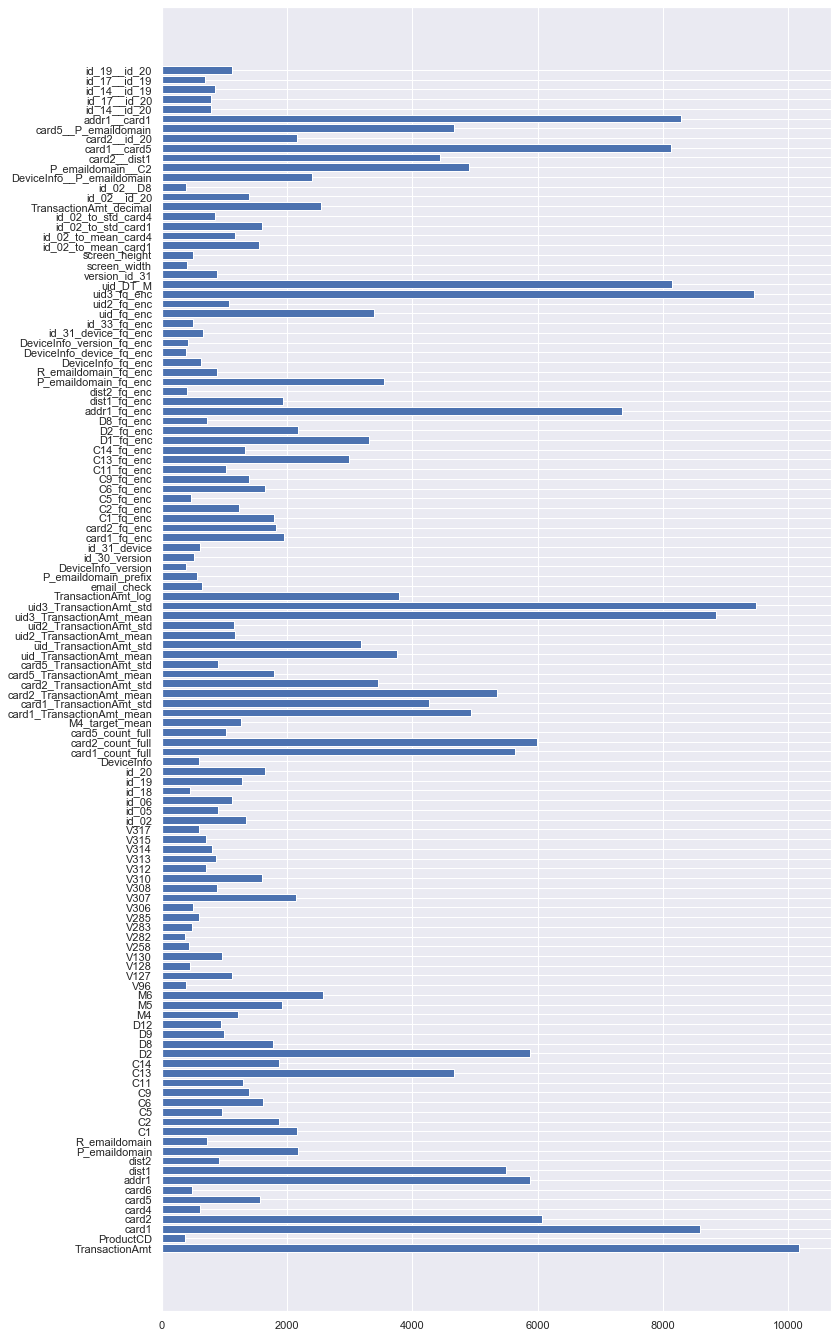

In [24]:
plt.figure(figsize=(12,24))
plt.barh(X_train.columns[estimator.feature_importance() > 375.5], estimator.feature_importance()[estimator.feature_importance() > 375.5])

In [25]:
usecols = X_subsample.columns[ estimator.feature_importance() > 375.5]
tr_data = lgb.Dataset(X_subsample[usecols], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols], label=y_valid)  
        
estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

# bestS: 0.912585, 0.915495, 0.9138(this one with random state=42)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.963282	valid_1's auc: 0.893793
[200]	training's auc: 0.977732	valid_1's auc: 0.900193
[300]	training's auc: 0.988459	valid_1's auc: 0.906675
[400]	training's auc: 0.994712	valid_1's auc: 0.910304
[500]	training's auc: 0.99781	valid_1's auc: 0.912076
[600]	training's auc: 0.999185	valid_1's auc: 0.912743
Early stopping, best iteration is:
[599]	training's auc: 0.999177	valid_1's auc: 0.912768


## Try adding new features

In [63]:
X_train['uid'] = X_train['card1'].astype(str)+'_'+X_train['card2'].astype(str)
X_valid['uid'] = X_valid['card1'].astype(str)+'_'+X_valid['card2'].astype(str)

X_train['C1_third_quartile'] = X_train.groupby('uid')['C1'].transform(lambda x: x > x.quantile(0.75))
X_valid['C1_third_quartile'] = X_valid.groupby('uid')['C1'].transform(lambda x: x > x.quantile(0.75))

del(X_train['uid'])
del(X_valid['uid'])

In [82]:
tr_data = lgb.Dataset(X_subsample[usecols+['C1_third_quartile']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols+['C1_third_quartile']], label=y_valid)  
        
estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

# bestS: 0.912585, 0.915495, 0.9138(this one with random state=42)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.963235	valid_1's auc: 0.893133
[200]	training's auc: 0.977635	valid_1's auc: 0.899513
[300]	training's auc: 0.988543	valid_1's auc: 0.905554
[400]	training's auc: 0.994786	valid_1's auc: 0.90913
[500]	training's auc: 0.997843	valid_1's auc: 0.911248
[600]	training's auc: 0.999206	valid_1's auc: 0.911886
Early stopping, best iteration is:
[582]	training's auc: 0.999039	valid_1's auc: 0.912052


In [83]:
tr_data = lgb.Dataset(X_subsample[usecols], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols], label=y_valid)  
        
estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100) 

# bestS: 0.912585, 0.915495, 0.9138(this one with random state=42)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.963312	valid_1's auc: 0.893436
[200]	training's auc: 0.977757	valid_1's auc: 0.900593
[300]	training's auc: 0.988429	valid_1's auc: 0.906785
[400]	training's auc: 0.99477	valid_1's auc: 0.910638
[500]	training's auc: 0.997846	valid_1's auc: 0.912298
[600]	training's auc: 0.999209	valid_1's auc: 0.913165
Early stopping, best iteration is:
[575]	training's auc: 0.998971	valid_1's auc: 0.913186


## automate

In [114]:
subsample_indices = X_subsample.index

In [117]:
# That stuff doesn't work
# 0.75 (uid base and extended): all False
# 0.9: all False

C_cols = [col for col in usecols if col.startswith('C') and '_' not in col]
for col in C_cols: 
    X_train['uid'] = X_train['card1'].astype(str)+'_'+X_train['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
    X_valid['uid'] = X_valid['card1'].astype(str)+'_'+X_valid['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
    
    X_train[col+'_third_quartile'] = X_train.groupby('uid')[col].transform(lambda x: x > x.quantile(0.9))
    X_valid[col+'_third_quartile'] = X_valid.groupby('uid')[col].transform(lambda x: x > x.quantile(0.9))
    
    del(X_train['uid'])
    del(X_valid['uid'])
    
    X_subsample = X_train.iloc[subsample_indices]
    
    tr_data = lgb.Dataset(X_subsample[usecols+[col+'_third_quartile']], label=y_subsample)
    vl_data = lgb.Dataset(X_valid[usecols+[col+'_third_quartile']], label=y_valid)  
        
    estimator3 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 0) 

    print(col, estimator3.best_score['valid_1']['auc'], estimator3.best_score['valid_1']['auc'] > 0.913186)
    
    del(X_train[col+'_third_quartile'])
    del(X_valid[col+'_third_quartile'])

C1 0.9128070752443954 False
C2 0.912398685548233 False
C5 0.9114113135574949 False
C6 0.9125528662730141 False
C9 0.9128291675781477 False
C11 0.9121922520401308 False
C13 0.9129456002485963 False
C14 0.9131691906087073 False


In [151]:
X_train['AMT_95'] = X_train.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_train['AMT_85'] = X_train.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_train['AMT_75'] = X_train.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_train['AMT_65'] = X_train.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_train['AMT_55'] = X_train.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_train['AMT_HH'] = X_train['AMT_55'] +X_train['AMT_65'] +X_train['AMT_75'] +X_train['AMT_85'] +X_train['AMT_95'] 
del(X_train['AMT_95'])
del(X_train['AMT_85'])
del(X_train['AMT_75'])
del(X_train['AMT_65'])
del(X_train['AMT_55'])
X_valid['AMT_95'] = X_valid.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_valid['AMT_85'] = X_valid.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_valid['AMT_75'] = X_valid.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_valid['AMT_65'] = X_valid.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_valid['AMT_55'] = X_valid.groupby('uid')['TransactionAmt'].transform(lambda x:  x > x.quantile(0.95))
X_valid['AMT_HH'] = X_valid['AMT_55'] +X_valid['AMT_65'] +X_valid['AMT_75'] +X_valid['AMT_85'] +X_valid['AMT_95'] 
del(X_valid['AMT_95'])
del(X_valid['AMT_85'])
del(X_valid['AMT_75'])
del(X_valid['AMT_65'])
del(X_valid['AMT_55'])

X_subsample = X_train.iloc[subsample_indices]

tr_data = lgb.Dataset(X_subsample[usecols+['AMT_HH']], label=y_subsample)
vl_data = lgb.Dataset(X_valid[usecols+['AMT_HH']], label=y_valid)  
        
estimator2 = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data, vl_data],
                verbose_eval = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.963322	valid_1's auc: 0.89309
[200]	training's auc: 0.977604	valid_1's auc: 0.899301
[300]	training's auc: 0.98853	valid_1's auc: 0.905579
[400]	training's auc: 0.994794	valid_1's auc: 0.909559
[500]	training's auc: 0.997846	valid_1's auc: 0.911508
[600]	training's auc: 0.999211	valid_1's auc: 0.91173
[700]	training's auc: 0.999741	valid_1's auc: 0.91213
[800]	training's auc: 0.999921	valid_1's auc: 0.912378
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999921	valid_1's auc: 0.912378


In [ ]:
# hors de la moyenne des paiements effectuées à cette heure là ? 
# reessayer avec les uid3